In [11]:
import os
import numpy as np
from datasets import DatasetDict,Dataset
from arguments import DataTrainingArguments, ModelArguments, VITSTrainingArguments
from vits_model import VitsModel
from transformers import AutoTokenizer,HfArgumentParser,set_seed
from trainer import vits_trainin   
from feature_extraction import VitsFeatureExtractor
from tqdm import tqdm
import torch
from IPython.display import Audio,Image
import matplotlib.pyplot as plt
import PIL
import plot
from accelerate.utils import ProjectConfiguration, is_wandb_available, set_seed
import wandb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
is_wandb_available()

True

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because you are not:
	a) running as an administrator or
	b) there is not at least one TCC device in the system



In [12]:
model = VitsModel.from_pretrained("facebook/mms-tts-ara",cache_dir="./")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-ara",cache_dir="./")
config = model.config
feature_extractor = VitsFeatureExtractor()

parser = HfArgumentParser((ModelArguments, DataTrainingArguments, VITSTrainingArguments))
model_args, data_args, training_args = parser.parse_json_file(json_file=os.path.abspath('finetune_config_ara.json'))

Some weights of VitsModel were not initialized from the model checkpoint at facebook/mms-tts-ara and are newly initialized: ['discriminator.discriminators.4.convs.1.weight', 'discriminator.discriminators.3.convs.1.bias', 'discriminator.discriminators.4.final_conv.bias', 'discriminator.discriminators.5.convs.2.weight', 'discriminator.discriminators.2.convs.0.weight', 'discriminator.discriminators.0.final_conv.weight', 'discriminator.discriminators.5.convs.4.bias', 'discriminator.discriminators.1.convs.4.weight', 'discriminator.discriminators.1.final_conv.weight', 'discriminator.discriminators.0.convs.3.bias', 'discriminator.discriminators.5.final_conv.weight', 'discriminator.discriminators.1.convs.0.weight', 'discriminator.discriminators.5.convs.0.weight', 'discriminator.discriminators.1.convs.3.bias', 'discriminator.discriminators.0.convs.3.weight', 'discriminator.discriminators.5.convs.3.bias', 'discriminator.discriminators.4.convs.1.bias', 'discriminator.discriminators.4.convs.0.weig

In [6]:
training_args.save_total_limit

In [7]:
training_args.adam_beta1

0.8

In [12]:

project_name = "Posterior_Decoder_Finetuning"
wandbKey = "6b9663a47062735193b9298ae35a15f982f92a9a"

wandb.login(key= wandbKey)
wandb.init(project= project_name,config = training_args.to_dict())

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [21]:
training_args.to_dict()

{'output_dir': './output',
 'overwrite_output_dir': True,
 'do_train': True,
 'do_eval': True,
 'do_predict': False,
 'evaluation_strategy': 'no',
 'prediction_loss_only': False,
 'per_device_train_batch_size': 1,
 'per_device_eval_batch_size': 1,
 'per_gpu_train_batch_size': None,
 'per_gpu_eval_batch_size': None,
 'gradient_accumulation_steps': 1,
 'eval_accumulation_steps': None,
 'eval_delay': 0,
 'learning_rate': 2e-05,
 'weight_decay': 0.0,
 'adam_beta1': 0.8,
 'adam_beta2': 0.99,
 'adam_epsilon': 1e-08,
 'max_grad_norm': 1.0,
 'num_train_epochs': 1,
 'max_steps': -1,
 'lr_scheduler_type': 'linear',
 'lr_scheduler_kwargs': {},
 'warmup_ratio': 0.01,
 'warmup_steps': 0,
 'log_level': 'passive',
 'log_level_replica': 'warning',
 'log_on_each_node': True,
 'logging_dir': './output\\runs\\Mar29_22-40-25_Mahmood-Anaam',
 'logging_strategy': 'steps',
 'logging_first_step': False,
 'logging_steps': 500,
 'logging_nan_inf_filter': True,
 'save_strategy': 'steps',
 'save_steps': 500,
 'sa

In [13]:
text = "  حاط نفسه في مع مواجهة مع مين"
inputs = tokenizer(text, return_tensors="pt")

set_seed(training_args.seed)
with torch.no_grad():
    output = model(**inputs)

input_padding_mask = inputs.attention_mask.unsqueeze(-1).float()
inputs['padding_mask']=input_padding_mask
Audio(output.waveform, rate=model.config.sampling_rate)


In [14]:
wandb.log({"full generations samples": [
            wandb.Audio(w, caption=f"Full generation sample {1}", sample_rate=model.config.sampling_rate)
            for w in output.waveform],})

In [16]:
model.decoder(output.spectrogram).shape

torch.Size([1, 1, 74752])

In [22]:
output.spectrogram.shape

torch.Size([1, 192, 292])

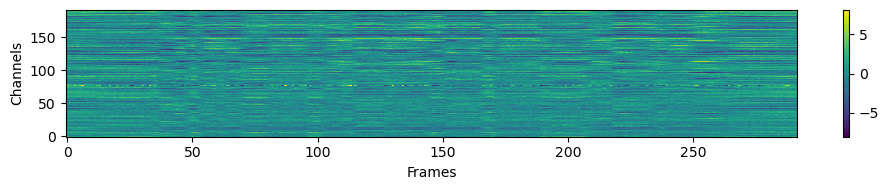

In [25]:
ig, ax = plt.subplots(figsize=(10, 2))
im = ax.imshow(output.spectrogram[0], aspect="auto", origin="lower", interpolation="none")

plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()

In [67]:
output.keys()

odict_keys(['waveform', 'sequence_lengths', 'spectrogram'])

In [68]:
output.waveform.shape

torch.Size([1, 74752])

In [52]:
output.spectrogram.shape

torch.Size([1, 192, 259])

In [54]:
output.sequence_lengths.shape

torch.Size([1])

In [15]:
output.sequence_lengths

tensor([66304])

In [56]:
training_args.save_steps

500

In [79]:
model

VitsModelSplit2(
  (text_encoder): VitsTextEncoder(
    (embed_tokens): Embedding(39, 192)
    (encoder): VitsEncoder(
      (layers): ModuleList(
        (0-5): 6 x VitsEncoderLayer(
          (attention): VitsAttention(
            (k_proj): Linear(in_features=192, out_features=192, bias=True)
            (v_proj): Linear(in_features=192, out_features=192, bias=True)
            (q_proj): Linear(in_features=192, out_features=192, bias=True)
            (out_proj): Linear(in_features=192, out_features=192, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (feed_forward): VitsFeedForward(
            (conv_1): Conv1d(192, 768, kernel_size=(3,), stride=(1,))
            (conv_2): Conv1d(768, 192, kernel_size=(3,), stride=(1,))
            (dropout): Dropout(p=0.1, inplace=False)
            (act_fn): ReLU()
          )
          (final_layer_norm): LayerNorm((192,), eps=1e-05,

In [70]:

out_text_encoder = model.text_encoder(**inputs)
out_text_encoder.keys()

odict_keys(['last_hidden_state', 'prior_means', 'prior_log_variances'])

In [44]:
model.text_encoder.project(out_text_encoder.last_hidden_state.transpose(1, 2)).shape

torch.Size([1, 384, 51])

In [96]:
model

VitsModelSplit2(
  (text_encoder): VitsTextEncoder(
    (embed_tokens): Embedding(39, 192)
    (encoder): VitsEncoder(
      (layers): ModuleList(
        (0-5): 6 x VitsEncoderLayer(
          (attention): VitsAttention(
            (k_proj): Linear(in_features=192, out_features=192, bias=True)
            (v_proj): Linear(in_features=192, out_features=192, bias=True)
            (q_proj): Linear(in_features=192, out_features=192, bias=True)
            (out_proj): Linear(in_features=192, out_features=192, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (feed_forward): VitsFeedForward(
            (conv_1): Conv1d(192, 768, kernel_size=(3,), stride=(1,))
            (conv_2): Conv1d(768, 192, kernel_size=(3,), stride=(1,))
            (dropout): Dropout(p=0.1, inplace=False)
            (act_fn): ReLU()
          )
          (final_layer_norm): LayerNorm((192,), eps=1e-05,

In [78]:
out_text_encoder.prior_log_variances.shape

torch.Size([1, 57, 192])

In [89]:
model.config.use_stochastic_duration_prediction

True

In [76]:
model.get_input_embeddings()

Embedding(39, 192)

In [20]:
model.text_encoder.embed_tokens(torch.LongTensor([17]))

tensor([[-8.7807e-02, -2.3058e-01,  1.3525e-02,  1.9309e-01, -1.2405e-01,
         -1.4646e-02, -4.0145e-02,  2.1352e-01,  8.0625e-02,  1.1350e-01,
         -1.8463e-03, -7.0758e-02, -1.5522e-02,  1.3135e-02, -2.7470e-01,
          1.0694e-01,  1.1932e-01, -2.8176e-01, -1.2434e-01,  2.8414e-02,
          1.8273e-01,  1.9413e-01,  1.3408e-01,  2.0573e-01,  1.1985e-01,
         -1.2867e-01,  6.6354e-02,  1.4110e-02,  2.4269e-01, -7.2437e-02,
         -8.6118e-02, -2.2489e-01,  1.5638e-01,  1.2869e-01,  1.1523e-01,
         -1.6241e-01,  1.8799e-01, -1.7715e-01,  6.6711e-03, -1.1621e-02,
          2.1841e-02,  1.1645e-02, -5.5614e-02,  9.1330e-02,  1.0110e-01,
          2.6628e-01, -7.7998e-02,  1.3481e-01, -1.4469e-01, -8.5860e-02,
          1.9676e-01, -2.3728e-01,  6.2738e-02,  6.1947e-02,  1.4959e-01,
         -2.0009e-01, -1.6452e-01,  1.5401e-01, -4.7271e-03, -1.1800e-01,
         -1.5511e-01, -5.2538e-02, -2.1530e-03,  9.5611e-03,  8.0660e-03,
         -1.2147e-01, -9.4708e-02, -6.

In [21]:
progress_bar = tqdm(
        range(0, 10),
        initial=0,
        desc="Steps",
        
        
       
        
    )

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
import time


for i in progress_bar:
    print(i)
    time.sleep(0.5)

0


Steps:  10%|█         | 1/10 [00:03<00:34,  3.84s/it]

1


Steps:  20%|██        | 2/10 [00:04<00:15,  1.88s/it]

2


Steps:  30%|███       | 3/10 [00:04<00:08,  1.25s/it]

3


Steps:  40%|████      | 4/10 [00:05<00:05,  1.05it/s]

4


Steps:  50%|█████     | 5/10 [00:05<00:03,  1.26it/s]

5


Steps:  60%|██████    | 6/10 [00:06<00:02,  1.44it/s]

6


Steps:  70%|███████   | 7/10 [00:06<00:01,  1.58it/s]

7


Steps:  80%|████████  | 8/10 [00:07<00:01,  1.69it/s]

8


Steps:  90%|█████████ | 9/10 [00:07<00:00,  1.77it/s]

9


Steps: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
